In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [3]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
start = pd.Timestamp('2023-05-23 13:00:00.000000')
now = pd.Timestamp.utcnow()
start,now

(Timestamp('2023-05-23 13:00:00'),
 Timestamp('2023-05-23 13:16:54.934044+0000', tz='UTC'))

In [6]:
filter_ = 'resource.labels.cluster_name="midori" AND ' + \
           'jsonPayload.method="submitNewBlockV2" AND ' + \
           '"optimistically parsed bid and verified signature" ' + \
           'AND timestamp>=' + '\"' + (start).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
           'AND timestamp<=' + '\"' + (now).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'
filter_

'resource.labels.cluster_name="midori" AND jsonPayload.method="submitNewBlockV2" AND "optimistically parsed bid and verified signature" AND timestamp>="2023-05-23T13:00:00.000000Z" AND timestamp<="2023-05-23T13:16:54.934044Z"'

In [7]:
res = []
subs = pd.DataFrame(columns=['slot', 'decode_dur', 'content_length'])
for e in client.list_entries(filter_=filter_):
    res.append((e.payload['decode_time'], e.payload['contentLength']))
res = np.asarray(res)
res.shape

(2294, 2)

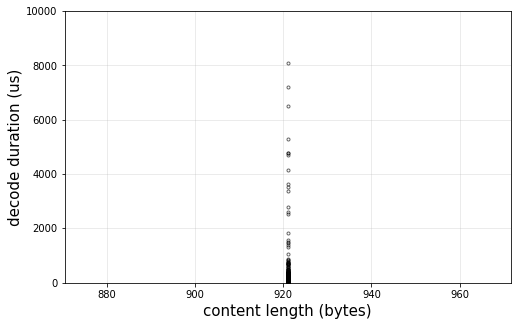

In [8]:
f, ax = plt.subplots(figsize=(8,5))

ax.plot(res[:,1], res[:,0], 'k.', fillstyle='none', alpha=0.6)

ax.set_ylim(-10, 10000)
ax.set_xlabel('content length (bytes)', size=15)
ax.set_ylabel('decode duration (us)', size=15)
plt.show()

In [9]:
durs = res[:,0]
durs[durs<10000]

array([ 37.,  41.,  36., ...,  57.,  44., 105.])

In [10]:
len(durs), len(durs[durs<10000])

(2294, 2232)

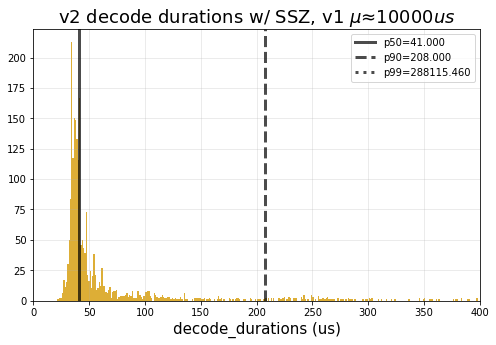

In [23]:
f, ax = plt.subplots(figsize=(8,5))

ax.hist(durs[durs<500], color='goldenrod', alpha=0.9, bins=400)

percs = [(int(i*100), np.quantile(durs, i)) for i in [.50, .90, .99]]
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)
# ax.axvline(durs.mean(), label='$\mu$={:0.3f}'.format(durs[durs<10000].mean()), color='mediumpurple', linewidth=3, alpha=0.7)

ax.legend(loc=1)
ax.set_xlabel('decode_durations (us)', size=15)
ax.set_title('v2 decode durations w/ SSZ, v1 $\mu ≈ 10000us$')
# ax.set_ylim(-10, 10000)
ax.set_xlim(0, 400)
plt.show()

In [37]:
res[:,0].per()

7831.44

In [14]:
durs

array([ 37.,  41.,  36., ...,  57.,  44., 105.])

In [16]:
st = ""
for i in [50, 75, 90, 99]:
    st += str(int(np.percentile(durs, i)))
    st += " & "
st

'41 & 61 & 208 & 288115 & '

In [2]:
june15 = pd.read_csv('june15-logs.csv')
june15.head()

,insertId,jsonPayload.level,jsonPayload.method,jsonPayload.msg,jsonPayload.service,jsonPayload.timeSinceEligibleAt,jsonPayload.timeSinceReceivedAt,jsonPayload.timestampEligible,jsonPayload.timestampExecutionPayloadSaved,jsonPayload.timestampRequestStarted,...,receiveTimestamp,resource.labels.cluster_name,resource.labels.container_name,resource.labels.location,resource.labels.namespace_name,resource.labels.pod_name,resource.labels.project_id,resource.type,severity,timestamp
0,vci78i9h63bnl9tq,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,17152,35529,1686834036524,1686834036543,1686834036560,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:36Z
1,bc7trrtsgmniz09g,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,76285,179717,1686834036095,1686834036199,1686834036275,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:36Z
2,9r7ffgqj10n0tq28,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,53222,63424,1686834036501,1686834036511,1686834036564,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:36Z
3,6e58kge6r30yps4i,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,74890,81612,1686834035931,1686834035938,1686834036012,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:36Z
4,cnz9zrxjcq9xi392,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,4953,7261,1686834035165,1686834035167,1686834035172,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:35Z


In [12]:
elig = june15['jsonPayload.timeSinceEligibleAt'].values
recv = june15['jsonPayload.timeSinceReceivedAt'].values

Text(0.5, 1.0, 'time to save payload')

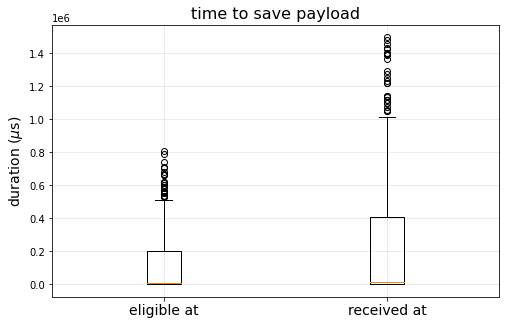

In [21]:
f, ax = plt.subplots(figsize=(8,5))
ax.boxplot([elig, recv])
ax.set_xticklabels(['eligible at', 'received at'], size=14)
ax.set_ylabel('duration ($\mu$s)', size=14)
ax.set_title('time to save payload', size=16)

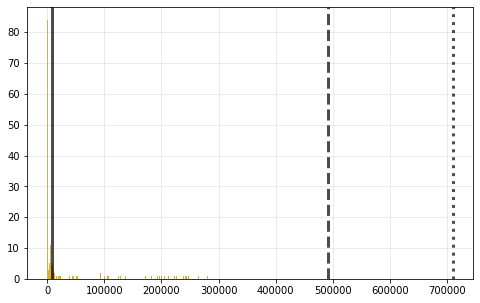

In [10]:
f, ax = plt.subplots(figsize=(8,5))

ax.hist(elig[elig<300000], color='goldenrod', alpha=0.9, bins=400)

percs = [(int(i*100), np.quantile(elig, i)) for i in [.50, .90, .99]]
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

# ax.legend(loc=1)
# ax.set_xlabel('decode_durations (us)', size=15)
# ax.set_title('v2 decode durations w/ SSZ, v1 $\mu ≈ 10000us$')
# # ax.set_ylim(-10, 10000)
# ax.set_xlim(0, 400)
plt.show()

In [16]:
june16 = pd.read_csv('june16.csv', delimiter="|", 
                  names=['slot', 'received_at', 'eligible_at', 'optimistic', 'decode_duration',
                         'prechecks_duration', 'simulation_duration', 'redis_update_duration', 'total_duration'])
june16.head()

,slot,received_at,eligible_at,optimistic,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration
0,6667561,2023-06-1513:12:26.015725,2023-06-1513:12:26.095507,f,1178,2284,73703,2619,79786
1,6667561,2023-06-1513:12:25.44035,2023-06-1513:12:25.496986,f,1041,2325,50867,2404,56638
2,6667561,2023-06-1513:12:26.885794,2023-06-1513:12:26.971436,f,28991,2328,51904,2422,85646
3,6667561,2023-06-1513:12:26.319878,2023-06-1513:12:26.393419,f,1041,2346,67999,2155,73544
4,6667561,2023-06-1513:12:27.817949,2023-06-1513:12:27.823882,t,1200,2720,8,2006,5936


In [21]:
len(june16[june16['optimistic']=='f'])

246003

In [22]:
printdf(june16[june16['optimistic']=='f'])

decode\_duration & 29000 & 99139 & 174945 & 570443 \\
prechecks\_duration & 2559 & 3479 & 13503 & 693552 \\
simulation\_duration & 126358 & 188810 & 534619 & 2460787 \\
redis\_update\_duration & 2487 & 3188 & 5670 & 217097 \\
\hline
\textbf{total\_duration} & \textbf{187575} & \textbf{321805} & \textbf{809080} & \textbf{3117146} \\


In [5]:
def printdf(df):
    print('decode\_duration & ', end='')
    st = ''
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['decode_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('prechecks\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['prechecks_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('simulation\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['simulation_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('redis\_update\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['redis_update_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('\\hline')
    print('\\textbf{total\_duration} & ', end='')
    for i in [50, 75, 90, 99]:
        st += '\\textbf{{{}}}'.format(str(int(np.percentile(df['total_duration'], i))))
        st += " & "
    print(st[:-3] + ' \\\\')

In [2]:
logs = pd.read_csv('downloaded-logs-20230616-124008.csv')
logs.head()

,insertId,jsonPayload.blockHash,jsonPayload.builderIsHighPrio,jsonPayload.builderPubkey,jsonPayload.cancellationEnabled,jsonPayload.contentLength,jsonPayload.fastTrackValidation,jsonPayload.floorBidValue,jsonPayload.headSlot,jsonPayload.isLargeRequest,...,receiveTimestamp,resource.labels.cluster_name,resource.labels.container_name,resource.labels.location,resource.labels.namespace_name,resource.labels.pod_name,resource.labels.project_id,resource.type,severity,timestamp
0,z6xzqajiubc8une1,0x4340a87305ce7b84021d40abf6449ff979e93bab6bf4...,True,0xabc387dff20ff4bda974b7f3041ea857d591681cc032...,NaN,23731,NaN,22895731439723095,6675794,NaN,...,2023-06-16T16:39:26.859069427Z,midori,builder-api,europe-west1-b,default,builder-api-f955b6888-znd78,ultra-sound-relay,k8s_container,INFO,2023-06-16T16:39:23Z
1,ykhbq5a4gc3s9xer,0x5ec85190e85ac9e9f9e9c9fc6e532100e1f0a9404719...,True,0xabc387dff20ff4bda974b7f3041ea857d591681cc032...,NaN,23528,True,22784169402358807,6675794,NaN,...,2023-06-16T16:39:23.732558013Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-xlgtk,ultra-sound-relay,k8s_container,INFO,2023-06-16T16:39:23Z
2,x78n0dr8zltwex1x,0xc165825921c2c079d30265b3cd562934c059bd5d57f9...,True,0x8aab0ed724d2c7f94af139bd2249ab511f08474ac69e...,True,21920,NaN,22895731439723095,6675794,NaN,...,2023-06-16T16:39:23.732558013Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-xlgtk,ultra-sound-relay,k8s_container,INFO,2023-06-16T16:39:23Z
3,wy9qwxm75rp6f3sj,0x811bb1e2b7640adb67d2250b8a612e0fd22773699bde...,True,0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4...,True,22024,NaN,22895731439723095,6675794,NaN,...,2023-06-16T16:39:28.741887392Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-xlgtk,ultra-sound-relay,k8s_container,INFO,2023-06-16T16:39:23Z
4,wxyxgd05phfodtez,0x61fa4f82083a09b0cb81b735455d4bbd323f88d6d85e...,True,0xabc387dff20ff4bda974b7f3041ea857d591681cc032...,NaN,24010,NaN,22895731439723095,6675794,NaN,...,2023-06-16T16:39:26.859069427Z,midori,builder-api,europe-west1-b,default,builder-api-f955b6888-znd78,ultra-sound-relay,k8s_container,INFO,2023-06-16T16:39:23Z


In [4]:
logs.keys()

Index(['insertId', 'jsonPayload.blockHash', 'jsonPayload.builderIsHighPrio',
       'jsonPayload.builderPubkey', 'jsonPayload.cancellationEnabled',
       'jsonPayload.contentLength', 'jsonPayload.fastTrackValidation',
       'jsonPayload.floorBidValue', 'jsonPayload.headSlot',
       'jsonPayload.isLargeRequest', 'jsonPayload.level', 'jsonPayload.method',
       'jsonPayload.msg', 'jsonPayload.newBidIsTopBid', 'jsonPayload.numTx',
       'jsonPayload.parentHash', 'jsonPayload.payloadBytes',
       'jsonPayload.prevTopBidValue', 'jsonPayload.profileDecodeUs',
       'jsonPayload.profilePrechecksUs',
       'jsonPayload.profileRedisSavePayloadUs',
       'jsonPayload.profileRedisUpdateFloorUs',
       'jsonPayload.profileRedisUpdateTopBidUs', 'jsonPayload.profileRedisUs',
       'jsonPayload.profileSimUs', 'jsonPayload.profileTotalUs',
       'jsonPayload.proposerPubkey', 'jsonPayload.reqContentType',
       'jsonPayload.reqIsGzip', 'jsonPayload.service', 'jsonPayload.slot',
       'jso

In [5]:
cl = logs['jsonPayload.contentLength']
pb = logs['jsonPayload.payloadBytes']
us = logs['jsonPayload.profileDecodeUs']

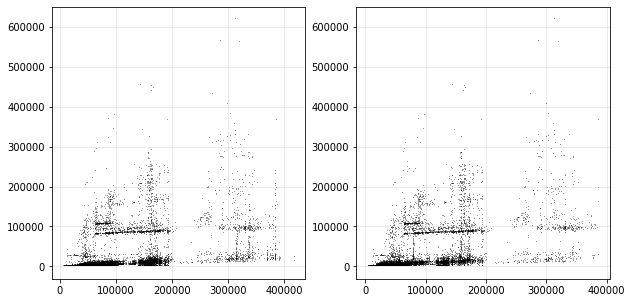

In [11]:
f, axarr = plt.subplots(figsize=(10,5), ncols=2)

axarr[0].plot(pb, us, 'k,', alpha=0.4)
axarr[1].plot(cl, us, 'k,', alpha=0.4)

plt.show()

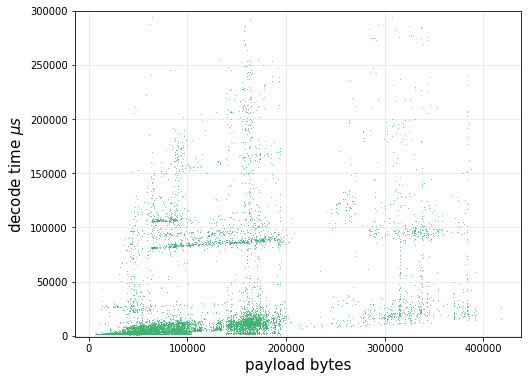

In [26]:
f, ax = plt.subplots(figsize=(8,6))

ax.plot(pb, us, ',', color='mediumseagreen', alpha=0.7)

ax.set_ylim(-1000, 300000)
ax.set_xlabel('payload bytes', size=15)
ax.set_ylabel('decode time $\mu s$', size=15)
plt.show()